<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_DeepLearning-LocalDiag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code from Part 1 Exercise - Satellite Imagery Data Preparation



In [1]:
!pip install patchify

In [2]:
!pip install segmentation-models tensorflow opencv-python-headless patchify --quiet --no-cache-dir


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
import sys
sys.path.append("drive")
import os
os.chdir('drive/MyDrive/Colab Notebooks')

In [ ]:
import re

scaler = MinMaxScaler() # Chuẩn hóa dữ liệu về dạng 0 -> 1
root_directory = 'Semantic segmentation dataset/Semantic segmentation dataset/'
patch_size = 256  # Kích thước hình ảnh 256x256x3

image_dataset = []  # Lưu trữ dataset của hình ảnh đầu vào

# Ban đầu, hình ảnh đầu vào sẽ có kích thước rất lớn ~ 797x644, 896x838, ...
# Bước 1: Chúng ta sẽ cần phải cắt từ các hình ảnh kích thước lớn thế này, thành các bức ảnh có kích thước nhỏ ví dụ: 256x256x3
# Bước 2: Để mà cắt được thì chúng ta sẽ phải đưa hình ảnh về kích thước là bội số của 256
"""
Ví dụ:
  Use patchify....
  Tile 1: 797 x 644 --> 768 x 512 --> 6
  Tile 2: 509 x 544 --> 512 x 256 --> 2
  Tile 3: 682 x 658 --> 512 x 512  --> 4
  Tile 4: 1099 x 846 --> 1024 x 768 --> 12
  Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
  Tile 6: 859 x 838 --> 768 x 768 --> 9
  Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
  Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
  Total 9 images in each folder * (145 patches) = 1305
  Total 1305 patches of size 256x256

"""

# Định nghĩa hàm sắp xếp các thư mục "Tile <số>" theo thứ tự số thứ tự
def sort_key(tile_name):
    # Sử dụng biểu thức chính quy để tìm số sau từ "Tile" trong tên thư mục
    match = re.search(r'Tile (\d+)', tile_name)
    return int(match.group(1)) if match else 0  # Trả về số để sắp xếp, hoặc 0 nếu không tìm thấy

#  Lấy danh sách thư mục "Tile" và sắp xếp theo thứ tự tăng dần của số thứ tự
tiles = sorted([subdir for subdir in os.listdir(root_directory) if subdir.startswith('Tile')], key=sort_key)

# Duyệt qua từng thư mục "Tile"
for tile in tiles:
    tile_path = os.path.join(root_directory, tile)
    for path, subdirs, files in os.walk(tile_path):
        dirname = path.split(os.path.sep)[-1]  # Lấy tên thư mục cuối cùng trong đường dẫn

        if dirname == 'images':  # Chỉ xử lý thư mục 'images'
            # Sắp xếp các file hình ảnh trong thư mục theo thứ tự
            images = sorted(os.listdir(path), key=lambda x: int(x.split('_')[-1].split('.')[0]))

            for image_name in images:
                if image_name.endswith(".jpg"):  # Chỉ xử lý hình ảnh có định dạng JPG
                    # Đọc hình ảnh dưới dạng BGR
                    image = cv2.imread(os.path.join(path, image_name), 1)
                    # Tính kích thước hình ảnh gần nhất có thể chia hết cho patch_size
                    SIZE_X = (image.shape[1] // patch_size) * patch_size
                    SIZE_Y = (image.shape[0] // patch_size) * patch_size
                    image = Image.fromarray(image)
                    # Cắt (crop) hình ảnh từ góc trên bên trái theo kích thước tính được
                    image = image.crop((0, 0, SIZE_X, SIZE_Y))
                    image = np.array(image)

                    # Tạo các ô (patches) từ hình ảnh, kích thước mỗi ô là patch_size x patch_size
                    print("Now patchifying image:", os.path.join(path, image_name))
                    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                    # Duyệt qua từng ô ảnh nhỏ đã tạo
                    for i in range(patches_img.shape[0]):
                        for j in range(patches_img.shape[1]):
                            # Lấy từng ô ảnh riêng lẻ từ patches
                            single_patch_img = patches_img[i, j, :, :]
                            # Chuẩn hóa từng ô ảnh về khoảng 0 -> 1
                            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                            # Bỏ đi chiều không cần thiết được thêm vào bởi patchify
                            single_patch_img = single_patch_img[0]
                            # Thêm ô ảnh chuẩn hóa vào dataset
                            image_dataset.append(single_patch_img)

In [ ]:
mask_dataset = []  # Danh sách để lưu trữ dataset của các mặt nạ (mask)

# Bước 1: Duyệt qua từng thư mục "Tile"
for tile in tiles:
    tile_path = os.path.join(root_directory, tile)
    for path, subdirs, files in os.walk(tile_path):
        dirname = path.split(os.path.sep)[-1]  # Lấy tên thư mục cuối cùng trong đường dẫn

        if dirname == 'masks':  # Chỉ xử lý thư mục 'masks'
            # Sắp xếp các file mặt nạ theo thứ tự
            masks = sorted(os.listdir(path), key=lambda x: int(x.split('_')[-1].split('.')[0]))

            for mask_name in masks:
                if mask_name.endswith(".png"):  # Chỉ xử lý các mặt nạ có định dạng PNG
                    # Đọc mặt nạ dưới dạng BGR
                    mask = cv2.imread(os.path.join(path, mask_name), 1)
                    # Chuyển đổi màu từ BGR sang RGB
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                    # Tính kích thước mặt nạ gần nhất có thể chia hết cho patch_size
                    SIZE_X = (mask.shape[1] // patch_size) * patch_size
                    SIZE_Y = (mask.shape[0] // patch_size) * patch_size
                    mask = Image.fromarray(mask)
                    # Cắt (crop) mặt nạ từ góc trên bên trái theo kích thước tính được
                    mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
                    mask = np.array(mask)

                    # Tạo các ô (patches) từ mặt nạ, kích thước mỗi ô là patch_size x patch_size
                    print("Now patchifying mask:", os.path.join(path, mask_name))
                    patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                    # Duyệt qua từng ô mặt nạ đã tạo
                    for i in range(patches_mask.shape[0]):
                        for j in range(patches_mask.shape[1]):
                            # Lấy từng ô mặt nạ riêng lẻ từ patches
                            single_patch_mask = patches_mask[i, j, :, :]
                            # Bỏ đi chiều không cần thiết được thêm vào bởi patchify
                            single_patch_mask = single_patch_mask[0]
                            # Thêm ô mặt nạ vào dataset
                            mask_dataset.append(single_patch_mask)


In [ ]:
# Chuyển hình ảnh về dạng np array
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [ ]:
# Show hình ảnh và mặt nạ tương ứng
import random
idx_random = random.randint(0,1305)
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
plt.imshow(image_dataset[idx_random])
plt.subplot(1,2,2)
plt.imshow(mask_dataset[idx_random])

In [ ]:
'''
Bảng mã màu của các nhãn (labels) trong ảnh mặt nạ:
Tòa nhà (Building): #3C1098
Khu đất chưa xây dựng (Land): #8429F6
Đường đi (Road): #6EC1E4
Thảm thực vật (Vegetation): #FEDD3A
Nước (Water): #E2A929
Chưa dán nhãn (Unlabeled): #9B9B9B
Mục tiêu:
Ảnh mặt nạ hiện tại có kích thước 256x256x3, mỗi pixel chứa màu RGB đại diện cho các lớp khác nhau.
Chúng ta cần chuyển ảnh mặt nạ từ RGB (256x256x3) thành nhãn (256x256x1), với mỗi giá trị nguyên biểu thị một lớp.
Ví dụ:

Pixel có màu #3C1098 (đại diện cho Tòa nhà) sẽ được gán nhãn là 0.
Pixel có màu #8429F6 (đại diện cho Đất) sẽ được gán nhãn là 1.
Tương ứng các nhãn:

0 - Tòa nhà
1 - Khu đất chưa xây dựng
2 - Đường đi
3 - Thảm thực vật
4 - Nước
5 - Chưa dán nhãn
Chuyển đổi giữa RGB và HEX
Chuyển đổi từ RGB sang HEX:

RGB là tổ hợp của ba giá trị (R, G, B), mỗi giá trị trong khoảng 0-255.
Để chuyển từng giá trị R, G, B sang HEX, thực hiện:
Chia cho 16 lấy phần nguyên (số đầu tiên trong HEX).
Phần dư là số thứ hai trong HEX.
Nếu phần nguyên hoặc phần dư là số từ 10-15, đổi thành ký tự từ A-F.
Ví dụ chuyển RGB sang HEX:

Cho R = 201:
Chia 201/16 được phần nguyên là 12 (C trong HEX).
Phần dư 9 là số HEX thứ hai.
Vậy mã HEX của R = 201 là C9.
Chuyển đổi từ HEX sang RGB:

HEX có 6 ký tự, mỗi cặp ký tự đại diện cho một trong các màu R, G, B.
Tính R, G, B từ HEX theo công thức:
Ký tự đầu tiên của cặp * 16 + ký tự thứ hai.
Ví dụ chuyển HEX sang RGB:

Mã HEX #3C1098:
R = 3C:
3 * 16 + C (12) = 60
G = 10:
1 * 16 + 0 = 16
B = 98:
9 * 16 + 8 = 152
Vậy mã RGB tương ứng là (60, 16, 152).
'''
# Xóa ký tự '#' ở đầu chuỗi HEX để xử lý dễ dàng hơn
Building = '#3C1098'.lstrip('#')
# Chuyển đổi chuỗi HEX của "Building" thành mã màu RGB
# - Lấy từng cặp ký tự HEX, chuyển đổi sang số thập phân, và tạo thành mảng RGB
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))  # Kết quả: [60, 16, 152]

# Lặp lại tương tự cho các lớp khác
# Lớp "Land"
Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))  # Kết quả: [132, 41, 246]

# Lớp "Road"
Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))  # Kết quả: [110, 193, 228]

# Lớp "Vegetation"
Vegetation = 'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))  # Kết quả: [254, 221, 58]

# Lớp "Water"
Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))  # Kết quả: [226, 169, 41]

# Lớp "Unlabeled" (chưa gán nhãn)
Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))  # Kết quả: [155, 155, 155]

# Biến `label` sẽ chứa nhãn của từng ô nhỏ (patch) từ ảnh mặt nạ (mask)
label = single_patch_mask

# Thay thế các giá trị RGB bằng các giá trị số nguyên để sử dụng làm nhãn.
# Tìm các pixel có màu RGB khớp với các mảng đã định nghĩa ở trên...
# Nếu khớp, thay thế tất cả giá trị trong pixel đó bằng một số nguyên cụ thể.

def rgb_to_2D_label(label):
    """
    Chuyển đổi ảnh mặt nạ từ định dạng RGB sang dạng nhãn 2D.
    Hàm này nhận ảnh mặt nạ dạng RGB và thay thế các pixel có giá trị RGB nhất định
    thành một nhãn (số nguyên) tương ứng với các lớp (class).
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)  # Khởi tạo mảng nhãn với giá trị ban đầu là 0
    label_seg[np.all(label == Building, axis=-1)] = 0  # Nếu pixel khớp với màu của "Building", gán nhãn là 0
    label_seg[np.all(label == Land, axis=-1)] = 1      # Nếu khớp với màu của "Land", gán nhãn là 1
    label_seg[np.all(label == Road, axis=-1)] = 2      # Nếu khớp với màu của "Road", gán nhãn là 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3  # Nếu khớp với màu của "Vegetation", gán nhãn là 3
    label_seg[np.all(label == Water, axis=-1)] = 4     # Nếu khớp với màu của "Water", gán nhãn là 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5  # Nếu khớp với màu "Unlabeled", gán nhãn là 5

    label_seg = label_seg[:, :, 0]  # Lấy kênh đầu tiên làm kết quả đầu ra, không cần giữ cả 3 kênh

    return label_seg

# Tạo danh sách chứa tất cả các nhãn từ ảnh mặt nạ
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])  # Chuyển đổi từng ảnh mặt nạ sang dạng nhãn 2D
    labels.append(label)

labels = np.array(labels)  # Chuyển danh sách labels thành mảng NumPy
labels = np.expand_dims(labels, axis=3)  # Thêm một trục mới để giữ định dạng của nhãn

# In ra các nhãn duy nhất trong tập dữ liệu để kiểm tra
print("Unique labels in label dataset are: ", np.unique(labels))

In [ ]:
# Tiếp theo là chúng ta sẽ cần phải chuyển đổi label thành dạng one hot tương ứng để train model
# Ví dụ có 6 class (0,1,2,3,4,5)
# khi đó: 0 -> [1 0 0 0 0 0] (dạng one hot)
# 1 -> [0 1 0 0 0 0] (dạng one hot)
# 2 -> [0 0 1 0 0 0] (dạng one hot)
# tương tự với các trường hợp còn lại

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes) # Chuyển tất cả label về dạng one hot

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm thử với kích thước 8 / 2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [ ]:
# Đặt trọng số cho từng lớp trong Dice Loss (có tổng bằng 1). Mỗi lớp đều được đặt trọng số bằng nhau.
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

# Tạo hàm mất mát Dice Loss với trọng số lớp đã định nghĩa.
dice_loss = sm.losses.DiceLoss(class_weights=weights)

# Tạo hàm mất mát Categorical Focal Loss, giúp tập trung vào các mẫu khó phân loại.
focal_loss = sm.losses.CategoricalFocalLoss()

# Tổng hợp hàm mất mát bằng cách kết hợp Dice Loss và Focal Loss, với trọng số 1 cho Focal Loss.
total_loss = dice_loss + (1 * focal_loss)

# Định nghĩa chiều cao, chiều rộng và số kênh của ảnh dựa trên tập huấn luyện.
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# Đặt các metric đánh giá mô hình gồm độ chính xác (accuracy) và hệ số Jacard (IoU).
metrics = ['accuracy', jacard_coef]

# Hàm trả về mô hình U-Net với các lớp đầu ra bằng số lớp của bài toán phân loại.
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# Khởi tạo mô hình U-Net với số lớp, chiều cao, chiều rộng, và kênh đã chỉ định.
model = get_model()

# Biên dịch mô hình với optimizer là Adam, sử dụng hàm mất mát là Categorical Crossentropy và các metric đã định nghĩa.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# Hiển thị tổng quan về kiến trúc mô hình.
model.summary()


In [ ]:
# Train model
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


66/66 ━━━━━━━━━━━━━━━━━━━━ 663s 10s/step - accuracy: 0.4388 - jacard_coef: 0.2194 - loss: 1.4025 - val_accuracy: 0.5967 - val_jacard_coef: 0.3405 - val_loss: 0.9663
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 649s 10s/step - accuracy: 0.6337 - jacard_coef: 0.3755 - loss: 0.9522 - val_accuracy: 0.7083 - val_jacard_coef: 0.4154 - val_loss: 0.8412
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 645s 10s/step - accuracy: 0.7236 - jacard_coef: 0.4493 - loss: 0.8010 - val_accuracy: 0.7048 - val_jacard_coef: 0.4300 - val_loss: 0.8245
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 642s 10s/step - accuracy: 0.7329 - jacard_coef: 0.4670 - loss: 0.7638 - val_accuracy: 0.7396 - val_jacard_coef: 0.4623 - val_loss: 0.7391
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 643s 10s/step - accuracy: 0.7393 - jacard_coef: 0.4774 - loss: 0.7394 - val_accuracy: 0.7385 - val_jacard_coef: 0.4766 - val_loss: 0.7387
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 640s 10s/step - accuracy: 0.7539 - jacard_coef: 0.4909 - loss: 0.7112 - val_accuracy: 0.7318 

KeyboardInterrupt: 

In [5]:
model.save('saved_model.h5')

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('saved_model.h5', custom_objects={'jacard_coef': jacard_coef})

In [ ]:
label_colors = {
    0: [60, 16, 152],     # Building
    1: [132, 41, 246],    # Land
    2: [110, 193, 228],   # Road
    3: [254, 221, 58],    # Vegetation
    4: [226, 169, 41],    # Water
    5: [155, 155, 155]    # Unlabeled
}

In [ ]:
def label_to_rgb(label_img):
    """
    Chuyển ảnh nhãn 2D (giá trị 0-5) thành ảnh RGB 3D (256x256x3)
    """
    h, w = label_img.shape
    rgb_img = np.zeros((h, w, 3), dtype=np.uint8)
    for label_val, color in label_colors.items():
        rgb_img[label_img == label_val] = color
    return rgb_img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


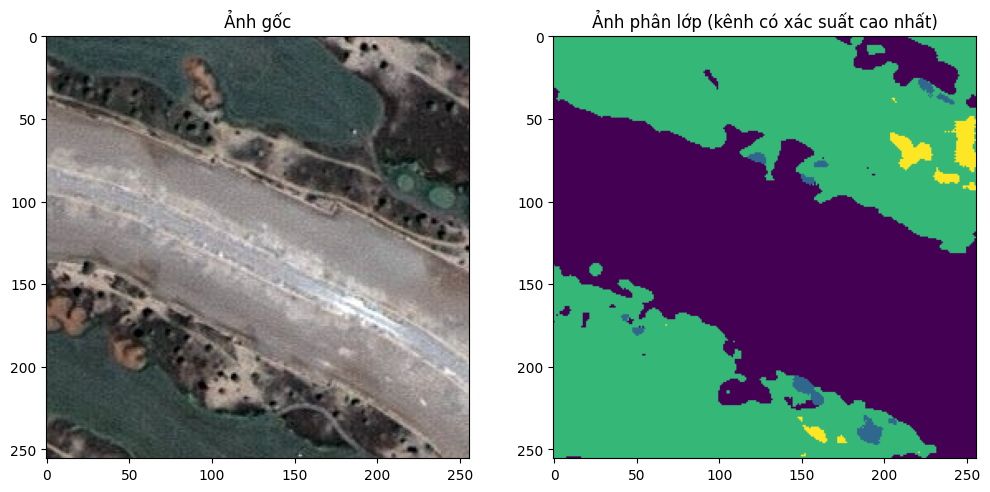

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Chọn một ảnh ngẫu nhiên từ dataset
idx_random = random.randint(0, 1305)
image = image_dataset[idx_random]

# Thêm chiều batch vào ảnh (1, 256, 256, 3)
image_with_batch = np.expand_dims(image, axis=0)

# Thực hiện dự đoán với mô hình
image_pred = model.predict(image_with_batch)

# Loại bỏ chiều batch của kết quả để có dạng (256, 256, 6)
image_pred = np.squeeze(image_pred, axis=0)

# Lấy chỉ số của kênh có xác suất cao nhất
image_pred_max = np.argmax(image_pred, axis=-1)

# Chuyển ảnh dự đoán (label dạng số) sang ảnh RGB
image_pred_rgb = label_to_rgb(image_pred_max)


# Hiển thị ảnh gốc và ảnh dự đoán
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Ảnh gốc")

plt.subplot(1, 2, 2)
plt.imshow(image_pred_max, cmap="viridis")  # sử dụng cmap phù hợp cho phân lớp
plt.title("Ảnh phân lớp (kênh có xác suất cao nhất)")

plt.show()


In [ ]:
# ========== Vẽ biểu đồ loss và metric ==========
# Kiểm tra nếu anh đã huấn luyện trước đó:
print(history1.history.keys())  # In ra các chỉ số metric

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.title('Biểu đồ Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Jacard (hoặc metric khác nếu dùng)
metric_name = 'jacard_coef'  # hoặc 'accuracy' nếu dùng accuracy
if metric_name in history1.history:
    plt.subplot(1, 2, 2)
    plt.plot(history1.history[metric_name], label='Training')
    plt.plot(history1.history['val_' + metric_name], label='Validation')
    plt.title(f'Biểu đồ {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
else:
    print(f"Không tìm thấy metric '{metric_name}' trong history!")

plt.tight_layout()
plt.show()

NameError: name 'history1' is not defined